In [1]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
wandb.init()
config = wandb.config

config.max_len = 11
config.buckets = 20

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

labels=["crackling_fire", "helicopter", "rain", "thunderstorm", "wind"]

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Saving vectors of label - 'wind': 100%|████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.30it/s]


In [3]:
# Loading train/test set
X_train, X_test, y_train, y_test = get_train_test()

In [4]:
# Setting channels to 1 to generalize stereo sound to 1 channel
channels = 1
config.epochs = 50
config.batch_size = 100

# Number of classes
num_classes = 5

# Reshape X_train and X_test to include a 4th dimension (channels)
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


1.0


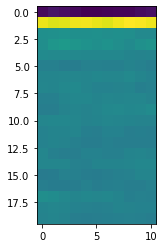

In [5]:
# Spectrogram visualized of 0th element
plt.imshow(X_train[1, :, :, 0])
print(y_train[1])

In [6]:
# Getting vector number where each number corresponds to a label
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [7]:
# Building the model
model = Sequential()

# Conv2D: 
#    Filters: 32
#    Kernel_size: (3,3) (height/width of the 2D convolution window)     
model.add(Conv2D(32, (3, 3),
    input_shape=(config.buckets, config.max_len, channels),
    activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [8]:
# Configure CNN for training
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [9]:
wandb.init()

# Train the CNN model
#    X_train: Input data
#    y_train_hot: Target data
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Train on 120 samples, validate on 80 samples
Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 33.5508 - accuracy: 0.125 - 0s 2ms/step - loss: 18.1951 - accuracy: 0.1833 - val_loss: 10.3962 - val_accuracy: 0.4000
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 17.4644 - accuracy: 0.250 - 0s 472us/step - loss: 8.6679 - accuracy: 0.4583 - val_loss: 4.0171 - val_accuracy: 0.3625
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 2.5825 - accuracy: 0.53 - 0s 519us/step - loss: 3.3282 - accuracy: 0.5583 - val_loss: 5.4318 - val_accuracy: 0.4625
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 4.2256 - accuracy: 0.62 - 0s 599us/step - loss: 2.1849 - accuracy: 0.6417 - val_loss: 4.0702 - val_accuracy: 0.4625
Epoch 5/50
120/120 [==============================] - ETA: 0s - loss: 1.8456 - accuracy: 0.59 - 0s 648us/step - loss: 1.7867 - accuracy: 0.6667 - val_loss: 2.7362 - val_accuracy: 0.5125
Epoch 6/50
120/120 [=

Epoch 45/50
120/120 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 1.00 - 0s 492us/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.5451 - val_accuracy: 0.6750
Epoch 46/50
120/120 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 1.00 - 0s 600us/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.5218 - val_accuracy: 0.6750
Epoch 47/50
120/120 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.00 - 0s 382us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 1.5415 - val_accuracy: 0.6750
Epoch 48/50
120/120 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 1.00 - 0s 454us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 1.5488 - val_accuracy: 0.6750
Epoch 49/50
120/120 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 1.00 - 0s 771us/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.5506 - val_accuracy: 0.6750
Epoch 50/50
120/120 [==============================] - ETA: 0s - 

In [10]:
# Save the keras model
model.save("geo_cnn_model.h5")
print("Model has been saved.")

Model has been saved.


## Running the IntelliChirp Biophony CNN

In [11]:
from keras.models import load_model

# Load the model
loaded_model = load_model('geo_cnn_model.h5')

In [12]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 9, 32)         320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               147584    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 148,549
Trainable params: 148,549
Non-trainable params: 0
_________________________________________________________________


In [26]:
## Running the model

# Convert wav to MFCC
prediction_data = wav2mfcc('./prediction/wind.wav')

# Reshape to 4 dimensions
prediction_data = prediction_data.reshape(1, config.buckets, config.max_len, channels)

# Run the model on the inputted file
predicted = loaded_model.predict(prediction_data)

# Output the prediction values for each class
print ('PREDICTED VALUES')
labels_indices = range(len(labels))
max_value = 0
max_value_index = 0
for index in labels_indices:
    print('\n', labels[index], ": ", '%.08f' % predicted[0,index])
    if predicted[0,index] > max_value:
        max_value_index = index
        max_value = predicted[0,index]

# Output the prediction
if max_value < 0.5:
    print("GUESS: Nothing")
else:
    print('\n\nGUESS: ', labels[max_value_index])
    
print(predicted[0])

PREDICTED VALUES

 crackling_fire :  0.42179796

 helicopter :  0.00178161

 rain :  0.00269044

 thunderstorm :  0.57372999

 wind :  0.00000001


GUESS:  thunderstorm
[4.2179796e-01 1.7816082e-03 2.6904407e-03 5.7372999e-01 1.4333640e-08]
